#### example.ipynb
**Demo example for the implementation of train-viz**<br>
by _Siddharth Yadav_ (syntax-surgeon)

In [2]:
# Importing neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Importing train-viz functions
from trainviz import make_map, plot_maps

# For crisper notebook graphics
%config InlineBackend.figure_formats = ["svg"]

In [3]:
# Function to generate the seven class dataset
def generate_doughnuts(samples_per_cluster=100, blur=2):
    A = [1, 1]
    B = [11, 1]
    C = [6, 5]
    D = [1, 8]
    E = [6, -1]
    F = [11, 8]
    G = [6, 10]

    A = torch.vstack((A[0]+torch.randn(samples_per_cluster)
                     * blur, A[1]+torch.randn(samples_per_cluster)*blur))
    B = torch.vstack((B[0]+torch.randn(samples_per_cluster)
                     * blur, B[1]+torch.randn(samples_per_cluster)*blur))
    C = torch.vstack((C[0]+torch.randn(samples_per_cluster)
                     * blur, C[1]+torch.randn(samples_per_cluster)*blur))
    D = torch.vstack((D[0]+torch.randn(samples_per_cluster)
                     * blur, D[1]+torch.randn(samples_per_cluster)*blur))
    E = torch.vstack((E[0]+torch.randn(samples_per_cluster)
                     * blur, E[1]+torch.randn(samples_per_cluster)*blur))
    F = torch.vstack((F[0]+torch.randn(samples_per_cluster)
                     * blur, F[1]+torch.randn(samples_per_cluster)*blur))
    G = torch.vstack((G[0]+torch.randn(samples_per_cluster)
                     * blur, G[1]+torch.randn(samples_per_cluster)*blur))

    labels = torch.hstack((torch.zeros(samples_per_cluster),
                           torch.ones(samples_per_cluster),
                           2*torch.ones(samples_per_cluster),
                           3*torch.ones(samples_per_cluster),
                           4*torch.ones(samples_per_cluster),
                           5*torch.ones(samples_per_cluster),
                           6*torch.ones(samples_per_cluster)))

    return torch.hstack((A, B, C, D, E, F, G)).T.float(), labels.long()

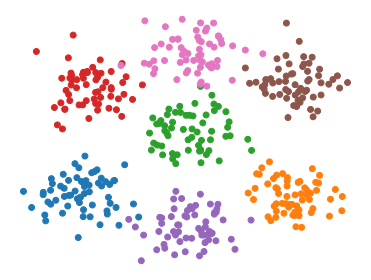

In [4]:
# Generating and visualizing data
samples_per_cluster = 60
blur = 1.1
data, labels = generate_doughnuts(samples_per_cluster=samples_per_cluster,
                                  blur=blur)

plt.scatter(data[:samples_per_cluster, 0], data[:samples_per_cluster, 1])
plt.scatter(data[samples_per_cluster:samples_per_cluster*2, 0],
            data[samples_per_cluster:samples_per_cluster*2, 1])
plt.scatter(data[samples_per_cluster*2:samples_per_cluster*3, 0],
            data[samples_per_cluster*2:samples_per_cluster*3, 1])
plt.scatter(data[samples_per_cluster*3:samples_per_cluster*4, 0],
            data[samples_per_cluster*3:samples_per_cluster*4, 1])
plt.scatter(data[samples_per_cluster*4:samples_per_cluster*5, 0],
            data[samples_per_cluster*4:samples_per_cluster*5, 1])
plt.scatter(data[samples_per_cluster*5:samples_per_cluster*6, 0],
            data[samples_per_cluster*5:samples_per_cluster*6, 1])
plt.scatter(data[samples_per_cluster*6:samples_per_cluster*7, 0],
            data[samples_per_cluster*6:samples_per_cluster*7, 1])

plt.axis('off');

In [5]:
# Defining the network
class ANNQC(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleDict()
        self.layers['input'] = nn.Linear(2, 8)
        self.layers['hidden_1'] = nn.Linear(8, 16)
        self.layers['hidden_2'] = nn.Linear(16, 8)
        self.layers['output'] = nn.Linear(8, 7)

    def forward(self, x):
        x = F.relu(self.layers['input'](x))
        x = F.relu(self.layers['hidden_1'](x))
        x = F.relu(self.layers['hidden_2'](x))
        x = self.layers['output'](x)
        return x


# Function for training the network
def train_ann(model, data, labels, num_epochs=500, learning_rate=0.002):
    # Defining the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Creating the data loader
    data_loader = DataLoader(TensorDataset(data, labels), batch_size=32)

    # For storing accuracies and plot maps (you need not save both types of maps)
    accuracies = torch.zeros(num_epochs)
    maps_b = [] # Boundary maps
    maps_r = [] # Region maps

    # Training the model
    for epoch in range(num_epochs):
        for X, y in data_loader:
            y_pred = model(X)  # Predictions
            loss = loss_fn(y_pred, y)  # Loss

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Saving the current epoch accuracy
        y_pred = model(data)
        current_accuracy = 100 * \
            torch.mean(
                (torch.argmax(F.softmax(y_pred, dim=1), axis=1) == labels).float())
        accuracies[epoch] = current_accuracy

        # Saving the class probability maps
        maps_b.append(make_map(model, xlim=(-3,15), ylim=(-5,14), epoch_num=epoch, epoch_freq=1, map_type="boundary"))
        maps_r.append(make_map(model, xlim=(-3,15), ylim=(-5,14), epoch_num=epoch, epoch_freq=1, map_type="region"))

    # Generating the final predictions and probability maps
    final_predictions = model(data)
    maps_b.append(make_map(model,xlim=(-3,15), ylim=(-5,14)))
    maps_r.append(make_map(model,xlim=(-3,15), ylim=(-5,14), map_type="region"))

    return final_predictions, accuracies, maps_b, maps_r

In [6]:
# Training parameters
num_epochs = 1000
learning_rate = 0.005

# Creating and training the model
model = ANNQC()
final_predictions, accuracies, ori_maps_b, ori_maps_r = train_ann(model,
                                                    data=data, labels=labels,
                                                    num_epochs=num_epochs,
                                                    learning_rate=learning_rate)
print(f"Final accuracy: {accuracies[-1]}")

Final accuracy: 97.38095092773438


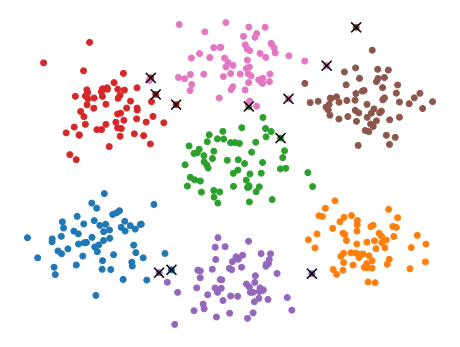

In [7]:
# Plotting the data with misclassified points
misclassified = data[torch.argmax(
    F.softmax(final_predictions, dim=1), axis=1) != labels]


plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(data[:samples_per_cluster, 0], data[:samples_per_cluster, 1])
plt.scatter(data[samples_per_cluster:samples_per_cluster*2, 0],
            data[samples_per_cluster:samples_per_cluster*2, 1])
plt.scatter(data[samples_per_cluster*2:samples_per_cluster*3, 0],
            data[samples_per_cluster*2:samples_per_cluster*3, 1])
plt.scatter(data[samples_per_cluster*3:samples_per_cluster*4, 0],
            data[samples_per_cluster*3:samples_per_cluster*4, 1])
plt.scatter(data[samples_per_cluster*4:samples_per_cluster*5, 0],
            data[samples_per_cluster*4:samples_per_cluster*5, 1])
plt.scatter(data[samples_per_cluster*5:samples_per_cluster*6, 0],
            data[samples_per_cluster*5:samples_per_cluster*6, 1])
plt.scatter(data[samples_per_cluster*6:samples_per_cluster*7, 0],
            data[samples_per_cluster*6:samples_per_cluster*7, 1])
plt.scatter(misclassified[:, 0], misclassified[:, 1],
            marker='x', color='black', s=100)

plt.axis('off');

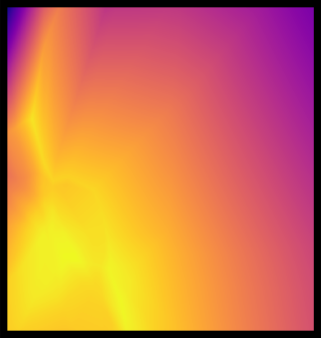

In [14]:
# Generating and saving the animation with boundary mode
animation_b = plot_maps(ori_maps_b, "animation_boundary.mp4", dark=True)

# Displaying the animation as an HTML video
HTML(animation_b.to_html5_video())

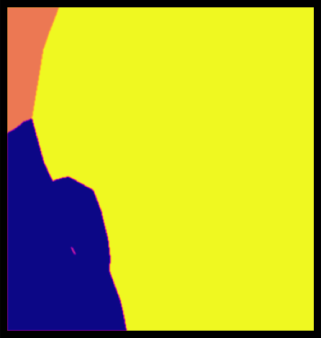

In [15]:
# Generating and saving the animation with region mode
animation_r = plot_maps(ori_maps_r, "animation_region.mp4", dark=True)

# Displaying the animation as an HTML video
HTML(animation_r.to_html5_video())